In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import reduce, partial
import scipy
from typing import Tuple
from importlib import reload
from cycler import cycler
from itertools import chain
# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 get_segments)


from writhe_tools.plots import (
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot,
                                build_matrix_boxplot_grid,
                                lineplot1D)

from writhe_tools.tcca import CCA, tCCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans, rotate_points, acf, pmf


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,                                 
                                   to_contacts
                                    )


from writhe_tools.utils import (lsdir,
                                group_by,
                                reindex_list,
                                contiguous_bool,
                                to_numpy,
                                num_str,
                                load_dict,
                                save_dict,
                                product
                                )


from typing import Dict, List, Tuple


import warnings
warnings.filterwarnings("ignore")



fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )



def fill_1d(x, values, indices):
    x[indices] = values
    return x

def fill(x, index, val):
    x[:, index] = val
    return x

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

ternary_bool = lambda distances : prod([to_contacts(i, 1).any(1) for i in split(distances)])

isin_index = lambda x, y : np.where(np.isin(x, y))[0]




def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              lower_upper: bool = False,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data) if data.ndim == 1 else data.mean(0)
    error = [res.confidence_interval.low, res.confidence_interval.high] if lower_upper\
            else (res.confidence_interval.high - res.confidence_interval.low) / 2
    if data.ndim > 1:error = np.stack(error)
    
    return mean, error


def group_contiguous_indices(indices):
    """
    Group sequential (contiguous) integer indices into runs.
    Parameters
    ----------
    indices : array-like of int
        Unordered collection of integer indices (e.g., [6, 1, 2, 3, 10]).
    Returns
    -------
    groups : list of np.ndarray
        Each element is a 1D NumPy array of contiguous integers, sorted ascending.
        Singletons (isolated indices) are included as length-1 arrays.
    Example
    -------
    >>> group_contiguous_indices([6, 1, 2, 3, 10])
    [array([1, 2, 3]), array([6]), array([10])]
    """
    if len(indices) == 0:
        return []
    idx = np.sort(np.unique(np.asarray(indices, dtype=int)))
    # Find boundaries where difference > 1 (i.e., gap)
    gaps = np.where(np.diff(idx) > 1)[0]
    # Split at those points (+1 because diff shrinks by 1)
    split_points = np.split(idx, gaps + 1)
    # Filter out empty splits (shouldn't happen but safe)
    groups = [np.array(run, dtype=int) for run in split_points if len(run) > 0]
    return groups


import numpy as np
import warnings


from pyblock.blocking import reblock, find_optimal_block
from collections import Counter

def block_error(x: np.ndarray, lower_upper: bool = False):
    """
    x : (N, d) numpy array with d features and N measurements
    """
    n = x.shape[0]
    blocks = reblock(x.T)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    optimal_indices=optimal_indices.astype(int)
    #op
    #print(optimal_indices[0])
    if x.ndim == 1:
        return lu_from_error(x.mean(), blocks[optimal_indices[0]].std_err.item()) if lower_upper else\
                (x.mean(), blocks[optimal_indices[0]].std_err.item())
    else:
        return lu_from_error(x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))\
                if lower_upper else (x.mean(0), np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))]))

def lu_from_error(mean, error):
    if all(isinstance(i, (float, int)) for i in (mean, error)):
        mean, error = [mean], [error]
    return mean, np.array([[mu - err, mu + err] for mu, err in zip(mean, error)]).T

# convenience (hard coded to 2 monomers) function to combine stats and prop error for averages to be taken over both monomers
def monomer_aggr_stats(x, 
                       error:callable=block_error, 
                       lower_upper: bool = False, 
                       fill_bool:np.ndarray=None):
    # compue mean and error over both monomers, aggregate, fill zeros for plotting, give lower, upper errors or absolute error
    ave, err = error(x, lower_upper=False)
    ave = np.add.reduce(split(x.mean(0))) / 2
    err = np.linalg.norm(err.reshape(2, -1), axis=0) / 2
    
    if lower_upper:
        # very simple error propogation here (arguably too simple)
        err = lu_from_error(ave, err)[-1]                   
        if fill_bool is not None:
            ave = fill_1d(np.zeros(len(fill_bool)), ave, fill_bool)
            err = np.stack([fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in err])

        return ave, err


    return (ave, err) if fill_bool is None else [fill_1d(np.zeros(len(fill_bool)), i, fill_bool) for i in [ave, err]]


#block_error(np.arange(10000), lower_upper=False)
path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
helix_pdb = '/data/r1r2/monomer_r1r2_helix.pdb'

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]


[writhe_tools] ⏭️ Skipping 'graph_utils' (missing: torch_geometric)
[writhe_tools] 👉 To enable this module, install: pip install writhe-tools[graph]


# Computations

In [2]:
# protein only calculations

label = 'EPI-002'
ca_selection = md.load(protein_pdb).top.select('name CA')
sequence, ca_index = get_residues(md.load(protein_pdb))
# 1 letter codes for the monomer sequence (just 1)

unitcell_lengths = traj=md.load(protein_files[1], top=protein_pdb).unitcell_lengths


ca_distances = ResidueDistances(index_0=np.arange(24),
                                index_1=np.arange(24, 48),
                                traj=md.load(protein_files[1], top=protein_pdb, atom_indices=ca_selection)
                               )

# dimer events from ca_distances
dimer = ca_distances.contacts(1).any(1)
dimer_events = contiguous_bool(bools=dimer)
dimer_lengths = 0.24 * np.fromiter(map(len, dimer_events), float) # scale by physical time

# sort by event length
sort = dimer_lengths.argsort()[::-1]
dimer_events = reindex_list(dimer_events, sort)
dimer_lengths = dimer_lengths[sort]

# structural features
sa = np.stack([calc_sa(md.load(protein_files[1], top=protein_pdb, atom_indices=j), helix_pdb) for j in split(ca_selection)])

dssp = np.where(md.compute_dssp(traj=md.load(protein_files[1], top=protein_pdb)) == 'H', 1, 0)[:, ca_index]

writhe = Writhe(xyz=md.load(protein_files[1], top=protein_pdb, atom_indices=ca_selection).center_coordinates().xyz)

#Writhe class will assume the whole protein is one chain be default - have to feed the segments manually to 
# result the fact that the two chains aren't connected 
# we are really just preventing the the class from making a single nonsense segment between the end and start residues of the two monomers
segments = np.concatenate([get_segments(index0=np.arange(24)),
                           get_segments(index0=np.arange(24, 48)),
                           get_segments(index0=np.arange(24), index1=np.arange(24, 48))
                          ])

writhe_features = writhe.compute_writhe(segments=segments,
                                        cuda=True,
                                        store_results=False,
                                        #lengths=unitcell_lengths,
                                        )['writhe_features']

# dimensionality reduction
tcca = tCCA(writhe_features, lag=10, dim=2,).fit()

# compute the projection and then 
proj = tcca.transform(writhe_features); 
#align to a reference because eigen vects might have flipped sign - NOT NEEDED, JUST FOR ASTHETIC (transformation is trivial)
proj = rotate_points(np.load(lsdir(paths[1], keyword='writhe_tcca_lag_')[0])[1:, :2],
                                                             proj, so3=False)

# to cluster with Kmeans
#dtraj, frames_cl = Kmeans(proj, n_clusters=10, n_dim=2)

# Kmeans isn't deterministic, so we use a pre computed clustering to keep consistency with reported values

## WARNING - MUST HAVE REFERNECE AVAILABLE FOR THIS TO WORK - CAN JUST COMMENT THIS OUT AND RECLUSTER USING LINES ABOVE
dtraj = load_dict('density_clusters.pkl')[1]; frames_cl = group_by(dtraj)
centroids = group_by(dtraj, proj, reduction = partial(np.mean, axis = 0))


In [15]:
#new tools for ligand interactions but general to computing Aromatics and Hbonds
from tools import Aromatics, HBonds, rm_index, t_stack, pi_stack
from writhe_tools.md_tools import canonical_residues

index=0 # first ligand trajectory (1aa is second one, e.i (index = 1))
# protein-ligand computations
sequence, ca_index = get_residues(md.load(ligand_pdbs[0]))
ligand_name = 'EPI0'
ligand_index = isin_index(sequence, ligand_name)

ligand_distances = ResidueDistances(traj=md.load(ligand_files[0], top=ligand_pdbs[0]), index_0=ligand_index, index_1=ca_index)

#ternary events from ligand distances (closest-heavy, contact cut-off of 0.6
ternary = np.multiply.reduce([i.any(1) for i in split(ligand_distances.contacts(0.6))])
ternary_events = contiguous_bool(bools=ternary)
ternary_lengths = 0.24 * np.fromiter(map(len, ternary_events), float) # scale by physical time

# sort by event length
sort = ternary_lengths.argsort()[::-1]
ternary_events = reindex_list(ternary_events, sort)
ternary_lengths = ternary_lengths[sort]

######################### ligand interactions ######################################################

########### Aromatic stacking ############

aro = Aromatics(md.load(ligand_files[index], top=ligand_pdbs[index]))
sequence, ca_index = get_residues(md.load(ligand_pdbs[index]))
aro_bool = np.isin(rm_index(sequence[ca_index])[:24], np.array(['TYR', 'HIS', 'TRP']))
# angles has [theta,phi,distance] in the last dimension
angles, pair_groups, pairs = aro.angles_between_groups(['EPI'], ['TYR', 'HIS', 'TRP'])
# apply cut offs, aggregate (logical OR) over residue-ligand pairs for all rings (two on the ligand here)
stacking = group_by(pair_groups, (t_stack(*angles.T) | pi_stack(*angles.T)).T , partial(np.any, axis=0)).T
print('Aromatic stacking pairs','\n', pairs)
# fill up an array of zeros so 
#stacking = fill(np.zeros((ligand_distances.distances.shape[0], 24), stacking, aro_bool)

########### Hbonds ########### 

not_proline = ~np.isin(rm_index(sequence[ca_index]), ['PRO']) # not needed here
hbond_class = HBonds(md.load(ligand_files[index], top=ligand_pdbs[index]))
groups = [canonical_residues, ['EPI']] # get ligand as donor and acceptor in the next line by interchanging args ([::-1])
# angles also has distance inside last dim
angles = [hbond_class.angles_between_groups(donor_group=i, acceptor_group=j) for i,j in zip(groups, groups[::-1])]
# this part is really optional if one seek a residue level description
hbonds = [hbond_class.hbonds_between_groups(angles=i)[0] for i in angles]
# the hbonds class returns a tuple with (hbond bools, groupings of hbonds, indexed pairs with a sequence index
# and an additional index in cases where a residue or ligand has multiple acceptor / donor sites.
# internally, the class will group interactions at the residue level using logical OR to conserve binary
print('protein donor pairs\n', angles[0][-1], 'ligand donor pairs\n', angles[1][-1])
# if proline is in sequence or the ligand can't function as a donor or acceptor, code will have to be ajusted accordingly
# here, the ligand can be both a donor and acceptor and there's no proline, so the post hoc sorting / indexing / filling, etc is not needed 
# hbonds[0] = fill(np.zeros_like(hbonds[1]), not_proline, hbonds[0])
# for simplicity sake, we're just going to redefine 'hbonds' as the total
hbonds =  np.logical_or.reduce(hbonds).T # lig as donor OR acceptor - gives unconditional interaction probability when mean is taken over fames 
print(f'max(Total HBonds) before taking the mean : {hbonds.max()}')

########### hyro-phobic ##############

# to simplify things, we can just remove all of the atoms except carbon and then use nearest heavy (defaul of ResidueDstances)
traj = md.load(ligand_files[index], top=ligand_pdbs[index],
               atom_indices = md.load(ligand_pdbs[index]).top.select('type C'),
               stride=1)

# note that sequence is a dynamic variable that redefined based on the results of sliced trajectories as the indices will change
sequence = get_residues(traj)[0]

hphob_contacts = ResidueDistances(traj=traj,
                                 index_0=isin_index(rm_index(sequence), canonical_residues),
                                 index_1=isin_index(sequence, np.array(['EPI0', 'LIG1']))
                                ).contacts(0.6)

del traj # keep traj objs out of memory to avoid overflow, only keep calc results (still may have issues w/ mem)

###### End Interactions calculations ##############

[23:04:36] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:04:37] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:04:37] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:38] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:38] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:04:38] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:38] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:38] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:04:39] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:39] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:04:39] Explicit valence for atom # 4 C, 7, is greater than permitted
[23:04:39] Explicit valence for atom # 4 C, 7, is g

Aromatic stacking pairs 
 [['EPI:0:0' 'TYR:4']
 ['EPI:0:0' 'TRP:8']
 ['EPI:0:0' 'TYR:17']
 ['EPI:0:0' 'HIS:24']
 ['EPI:0:0' 'TYR:30']
 ['EPI:0:0' 'TRP:34']
 ['EPI:0:0' 'TYR:43']
 ['EPI:0:0' 'HIS:50']
 ['EPI:0:1' 'TYR:4']
 ['EPI:0:1' 'TRP:8']
 ['EPI:0:1' 'TYR:17']
 ['EPI:0:1' 'HIS:24']
 ['EPI:0:1' 'TYR:30']
 ['EPI:0:1' 'TRP:34']
 ['EPI:0:1' 'TYR:43']
 ['EPI:0:1' 'HIS:50']]
protein donor pairs
 [['LEU:2' 'EPI:0:0']
 ['LEU:2' 'EPI:0:1']
 ['LEU:2' 'EPI:0:2']
 ['LEU:2' 'EPI:0:3']
 ['LEU:2' 'EPI:0:4']
 ['ASP:3' 'EPI:0:0']
 ['ASP:3' 'EPI:0:1']
 ['ASP:3' 'EPI:0:2']
 ['ASP:3' 'EPI:0:3']
 ['ASP:3' 'EPI:0:4']
 ['TYR:4:0' 'EPI:0:0']
 ['TYR:4:0' 'EPI:0:1']
 ['TYR:4:0' 'EPI:0:2']
 ['TYR:4:0' 'EPI:0:3']
 ['TYR:4:0' 'EPI:0:4']
 ['TYR:4:1' 'EPI:0:0']
 ['TYR:4:1' 'EPI:0:1']
 ['TYR:4:1' 'EPI:0:2']
 ['TYR:4:1' 'EPI:0:3']
 ['TYR:4:1' 'EPI:0:4']
 ['GLY:5' 'EPI:0:0']
 ['GLY:5' 'EPI:0:1']
 ['GLY:5' 'EPI:0:2']
 ['GLY:5' 'EPI:0:3']
 ['GLY:5' 'EPI:0:4']
 ['SER:6' 'EPI:0:0']
 ['SER:6' 'EPI:0:1']
 ['SER:6' 'EPI:0:

atoms = np.array(list(md.load(ligand_pdbs[index]).top.atoms))
print('all possible acceptor atoms\n\n', atoms[np.array(list(hbond_class.acc_atom_to_res.keys()))],
      '\n\nall possible donor atoms\n\n',atoms[hbond_class.donors_array.flatten()].reshape(-1, 2))

 # Ligand Interactions plot

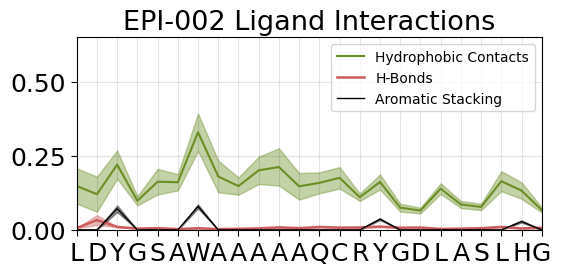

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
mu, err = monomer_aggr_stats(hphob_contacts, lower_upper=True)
scale = 1.5
lineplot1D(mu,
           color='olivedrab', fill_color='olivedrab', fill_alpha=.4,
           label='Hydrophobic Contacts', ax=ax, y1=err[0], y2=err[1], font_scale=scale)


mu, err = monomer_aggr_stats(hbonds, lower_upper=True)
lineplot1D(mu,
         color='indianred',
         fill_color='indianred',
         fill_alpha=.4,
         label='H-Bonds',
         ax=ax,
         alpha=1,
         lw=1.8,
         y1=err[0],
         y2=err[1],
         font_scale=scale
        )

mu, err = monomer_aggr_stats(stacking, lower_upper=True, fill_bool=aro_bool)
lineplot1D(mu,
         color='black',
         fill_color='black',
         y1=err[0],
         y2=err[1],
         fill_alpha=.4,
         ls='-',
         lw=1,
         label='Aromatic Stacking',
         ax=ax,
         #top_xticks=['', 395, 400, 405, 410, ''],
         xticks=codes[:24],
         xticks_rotation=0,
         title=f'{labels[1+index]} Ligand Interactions',
         font_scale=scale
        )

ax.set_ylim(0, .65)
#ax.grid(which='major', visible=True, axis='y')
ax.grid(which='major', color='black', linestyle='-', linewidth=0.8, axis='both', alpha=.1)
ax.legend()
fig.savefig(f'{paths[1]}/ligand_interactions.png', dpi=1000, bbox_inches='tight')

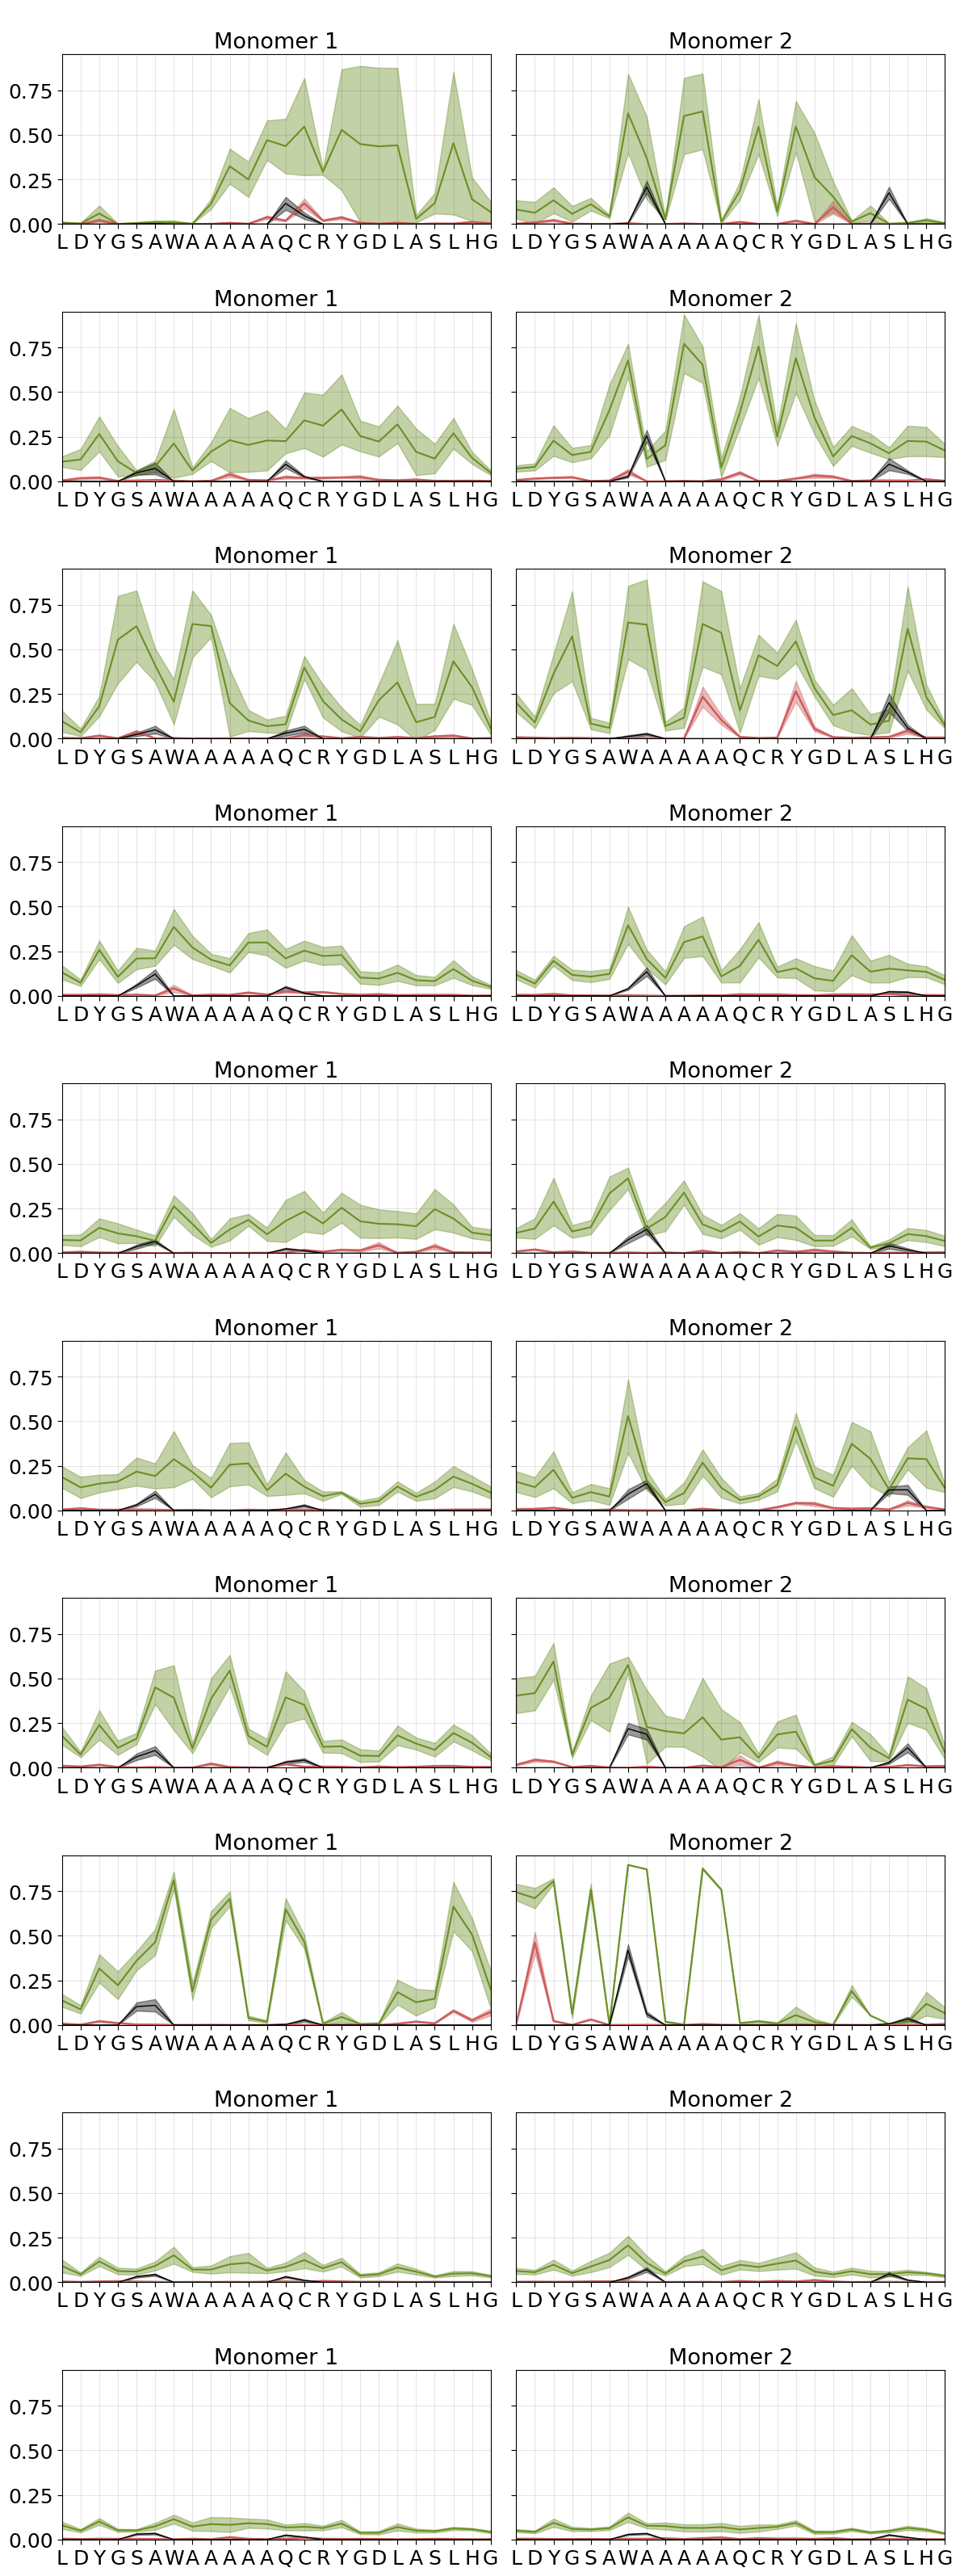

In [5]:
fig, axes = plt.subplots(10, 2, figsize=(12, 32), sharex=False, sharey=True)
font_scale=1.5
for i, (ax, frames) in enumerate(zip(axes, frames_cl)):
    
    mu, error = block_error(hphob_contacts[frames],
                          #confidence_level=.95,
                          lower_upper=True)
    mu, error = np.array_split(mu, 2,), [np.array_split(i, 2) for i in error]
    #mu, err = monomer_aggr_stats(hphob_contacts[frames], lower_upper=True, error=bootstrap)
    lineplot1D(mu[0],
               color='olivedrab',
               fill_color='olivedrab', fill_alpha=.4,
               label='Hydrophobic Contacts',
               ax=ax[0], y1=error[0][0],
               y2=error[1][0], legend=False, title='\nMonomer 1',
               font_scale=font_scale)
    
    lineplot1D(mu[1],
               color='olivedrab', fill_color='olivedrab', fill_alpha=.4,
               label='Hydrophobic Contacts', ax=ax[1], y1=error[0][1],
               y2=error[1][1], legend=False,title='\nMonomer 2',
               font_scale=font_scale)
    
    
    mu, error = block_error(hbonds[frames],
                          #confidence_level=.95,
                          lower_upper=True)
    mu, error = np.array_split(mu, 2,), [np.array_split(i, 2) for i in error]
    lineplot1D(mu[0],
             color='indianred',
             fill_color='indianred',
             fill_alpha=.4,
             label='H-Bonds',
             ax=ax[0],
             alpha=1,
             lw=1.8,
             y1=error[0][0],
             y2=error[1][0],
             legend=False,title='\nMonomer 1', 
             font_scale=font_scale
            )
    #ax.axvline(x=23.5, color='k', linestyle='-', linewidth=2)

    lineplot1D(mu[1],
             color='indianred',
             fill_color='indianred',
             fill_alpha=.4,
             label='H-Bonds',
             ax=ax[1],
             alpha=1,
             lw=1.8,
             y1=error[0][1],
             y2=error[1][1],
             legend=False, title='\nMonomer 2',
             font_scale=font_scale
            )

    mu, error = block_error(stacking[frames],
                            #confidence_level=.95,
                            lower_upper=True)
    mu, error = fill_1d(np.zeros(48), mu, np.repeat(aro_bool, 2)), [fill_1d(np.zeros(48), i, np.repeat(aro_bool, 2)) for i in error]
    mu, error = np.array_split(mu, 2,), [np.array_split(i, 2) for i in error]
    
    lineplot1D(mu[0],
             color='black',
             fill_color='black',
             y1=error[0][0],
             y2=error[1][0],
             fill_alpha=.4,
             ls='-',
             lw=1,
             label='Aromatic Stacking',
             ax=ax[0],
             label_stride=1,
             #top_xticks=['', 395, 400, 405, 410, ''],
             xticks=codes,
             xticks_rotation=0,
             title='\nMonomer 1',
             #title=f'State {i+1}',
             legend=False,
             font_scale = font_scale,
             
             #xlabel='Monomer 1                       Monomer 2'
             
            )
    lineplot1D(mu[1],
             color='black',
             fill_color='black',
             y1=error[0][1],
             y2=error[1][1],
             fill_alpha=.4,
             ls='-',
             lw=1,
             label='Aromatic Stacking',
             ax=ax[1],
             #top_xticks=['', 395, 400, 405, 410, ''],
             xticks=codes[:24],
             xticks_rotation=0,
             title='\nMonomer 2',
             #title=f'State {i+1}',
             legend=False,
             font_scale = font_scale
            )
    
    #if i == 0:
        #ax[1].legend(bbox_to_anchor=[1, 1])
    ax[0].set_ylim(0, .95)
    #ax.grid(which='major', visible=True, axis='y')
    ax[0].grid(which='major', color='black', linestyle='-', linewidth=0.8, axis='both', alpha=.1)
    #ax[0].tick_params(axis='x', labelsize=10)
    
    ax[1].set_ylim(0, .95)
    #ax.grid(which='major', visible=True, axis='y')
    ax[1].grid(which='major', color='black', linestyle='-', linewidth=0.8, axis='both', alpha=.1)
    #ax[1].tick_params(axis='x', labelsize=10)

fig.tight_layout()


fig.savefig(f'{paths[1]}/ligand_interactions_clusters.png', dpi=1000, bbox_inches='tight')
#fig.legend(bbox_to_anchor=[1.3, .9])

 # Visualize latent space

In [6]:

fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.5,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

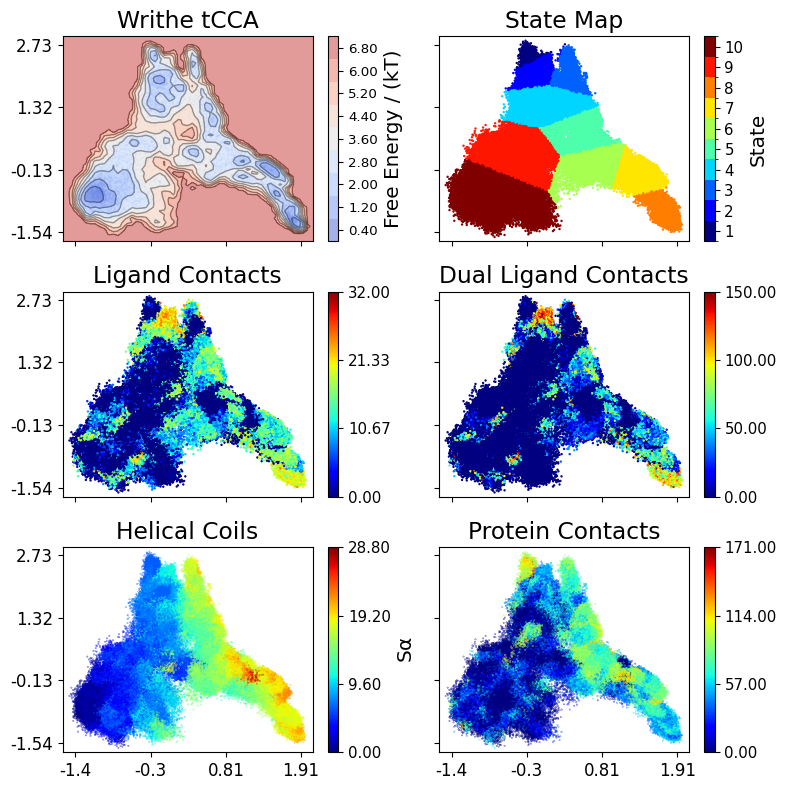

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(8, 8), sharey=True, sharex=True)
ax=ax.flat
fes2d(proj,
      #cluster_centers=centroids,
      ax=ax[0],
      mask_thresh=5,
      **fes2d_args,
      title='Writhe tCCA',
      font_scale=1.2)

proj2d(proj, 
       ax=ax[1],
       c=dtraj,
       state_map=True,
       cmap='jet',
       title = 'State Map',
       font_scale=1.2)

proj2d(proj, 
       ax=ax[2],
       c=ligand_distances.contacts(0.6).sum(-1),
       cmap='jet',
       title = 'Ligand Contacts',
       font_scale=1.2)

proj2d(proj, 
       ax=ax[3],
       c=np.multiply.reduce([i.sum(-1) for i in split(ligand_distances.contacts(0.6))]),
       cmap='jet',
       title = 'Dual Ligand Contacts',
       font_scale=1.2,
       vmax=150)

proj2d(proj,  ax=ax[4], c=sa.sum((0,2)),
       cmap='jet', title = 'Helical Coils',
       font_scale=1.2,dot_size=.05,
       vmin=0, cbar_label=r'S$\alpha$')

proj2d(proj, 
       ax=ax[5],
       c=ca_distances.contacts(1).sum(-1),
       cmap='jet',
       title = 'Protein Contacts',
       font_scale=1.2,
       vmin=0,
       dot_size=.05)

fig.tight_layout()
fig.savefig(f'{paths[1]}/projections.png', dpi=1000, bbox_inches='tight')

 # protein contacts (CA-CA distance < 1 nm) and helical propensities (DSSP algorithm)

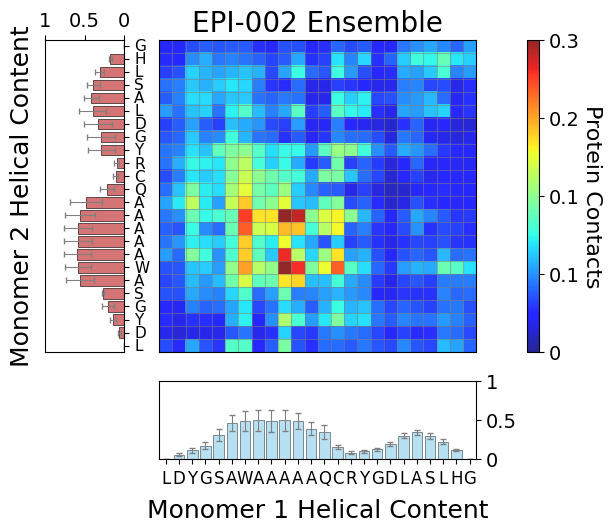

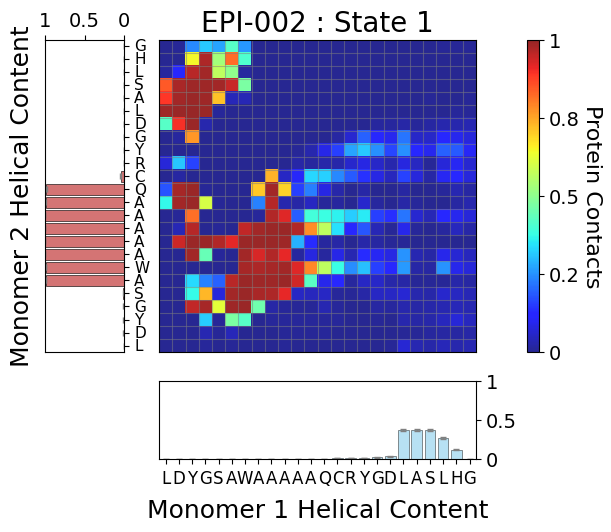

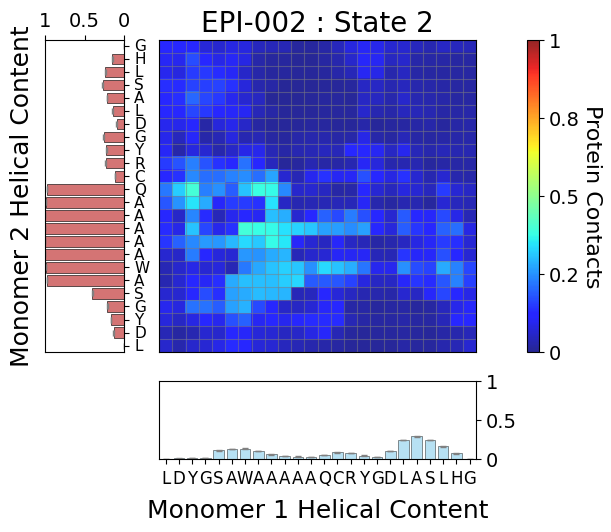

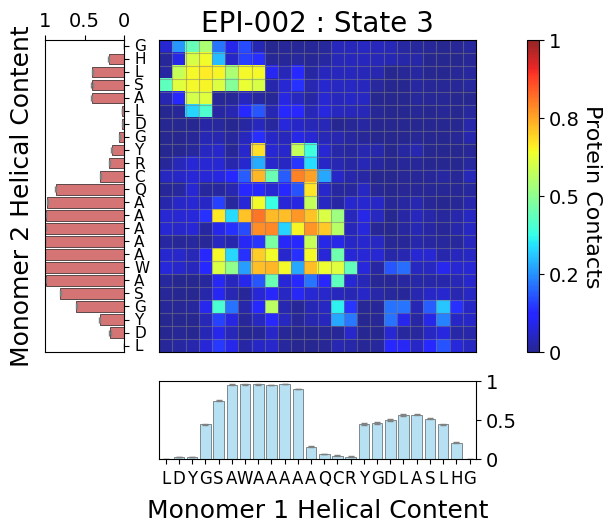

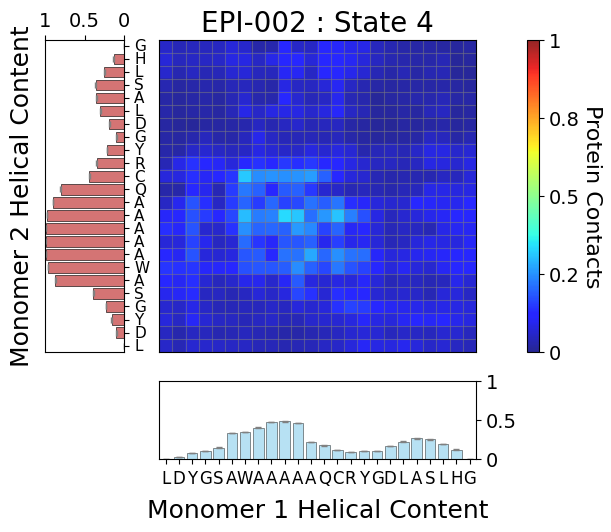

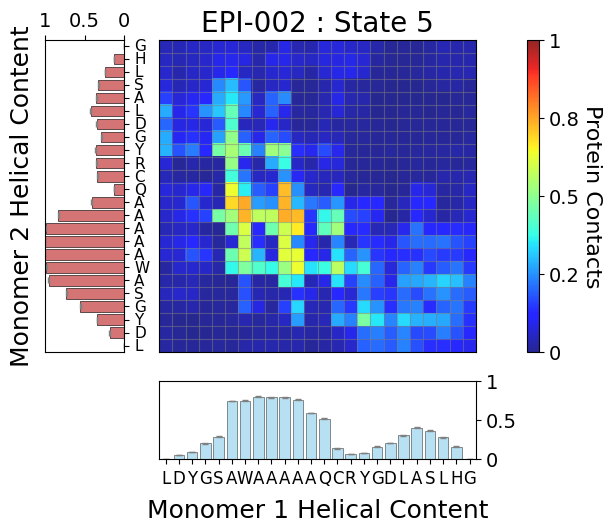

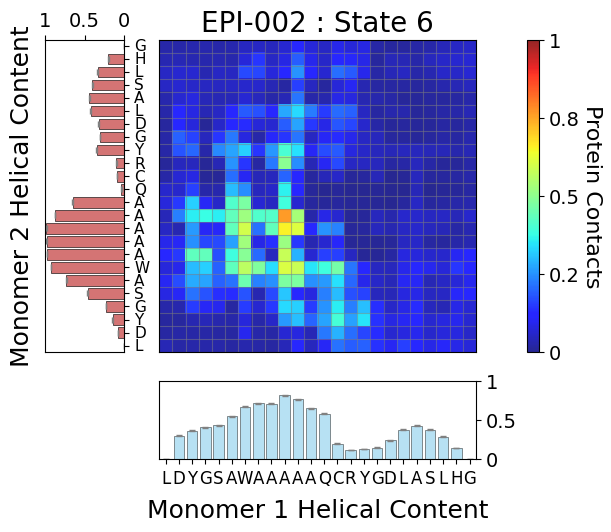

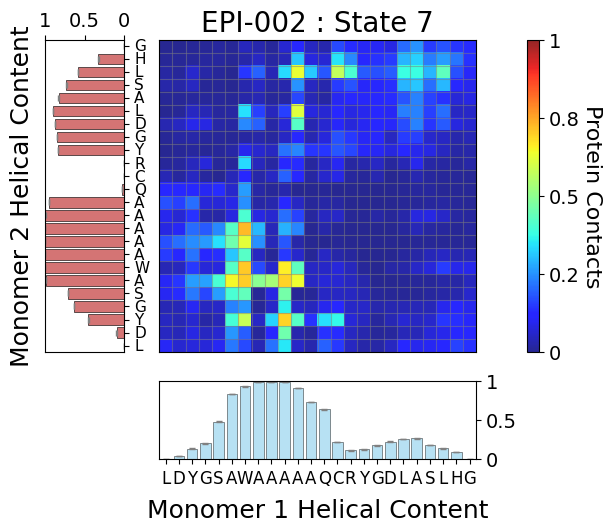

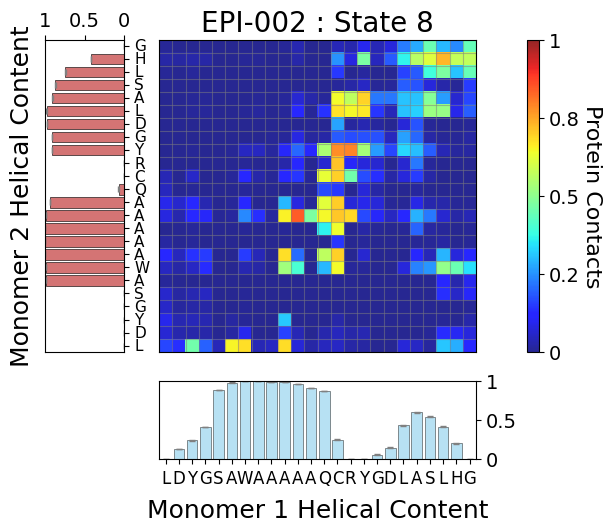

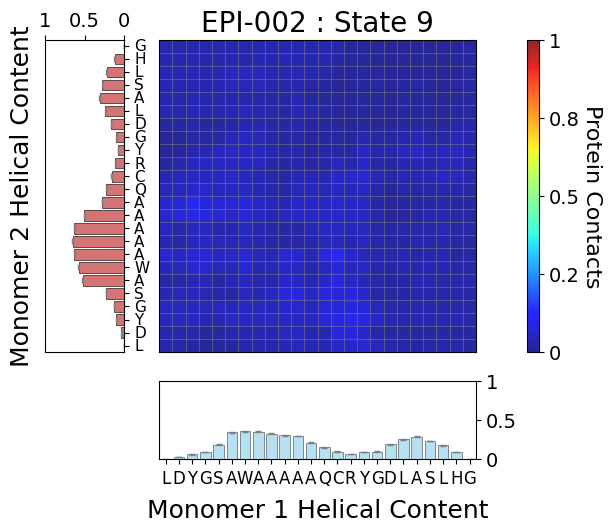

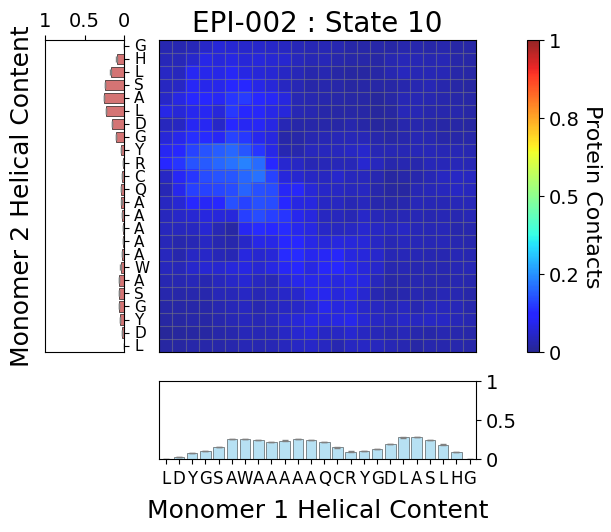

In [8]:

from writhe_tools.plots import build_matrix_boxplot_grid
dssp_error = split(block_error(dssp)[1])
build_matrix_boxplot_grid(ca_distances.matrix(contacts=True, cut_off=1).mean(0).T,
                          dssp[:,:24].mean(0),
                          dssp[:,24:].mean(0),
                          bottom_errors=dssp_error[0],
                          left_errors=dssp_error[1],
                          cmap='jet',
                          title=f'{label} Ensemble',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0,
                          vmax=.3,
                          marginal_max=1,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein Contacts',
                          ticks=codes,
                          ecolor='gray',
                          path=f'{paths[1]}/protein_protein_helix_ensemble.png'
                         )
for i, frames in enumerate(frames_cl):
    
    dssp_error = split(bootstrap(dssp[frames], 0.95)[1])

    build_matrix_boxplot_grid(ca_distances.matrix(contacts=True, cut_off=1, index=frames).mean(0).T,
                          dssp[frames, :24].mean(0),
                          dssp[frames, 24:].mean(0),
                          bottom_errors=dssp_error[0],
                          left_errors=dssp_error[1],
                          cmap='jet',
                          title=f'{label} : State {i+1}',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0,
                          vmax=1,
                          marginal_max=1,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein Contacts',
                          ticks=codes,
                          path=f'{paths[1]}/protein_protein_helix_state_{i+1}.png')
    


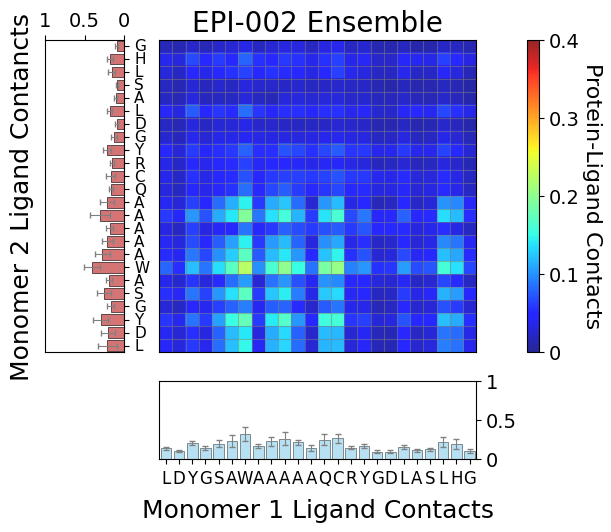

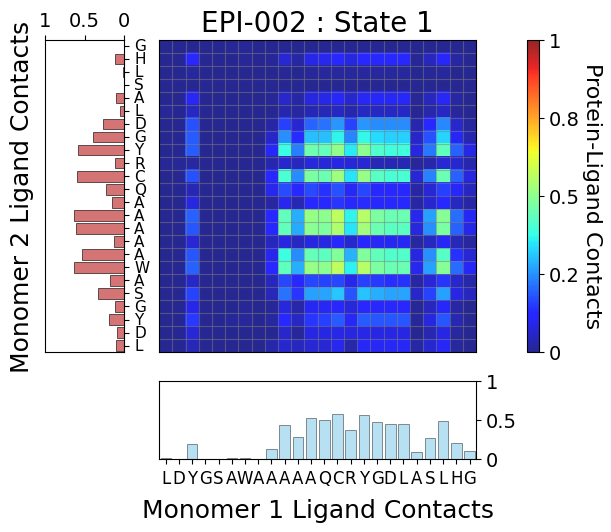

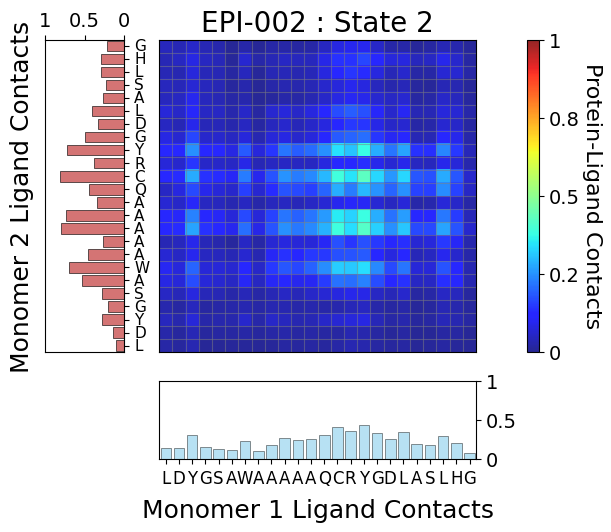

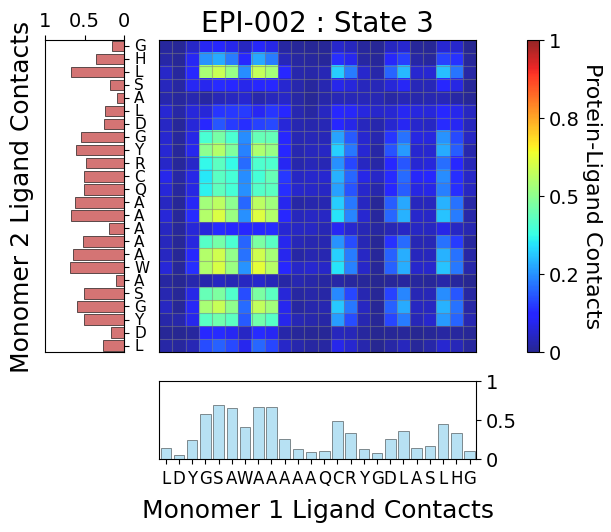

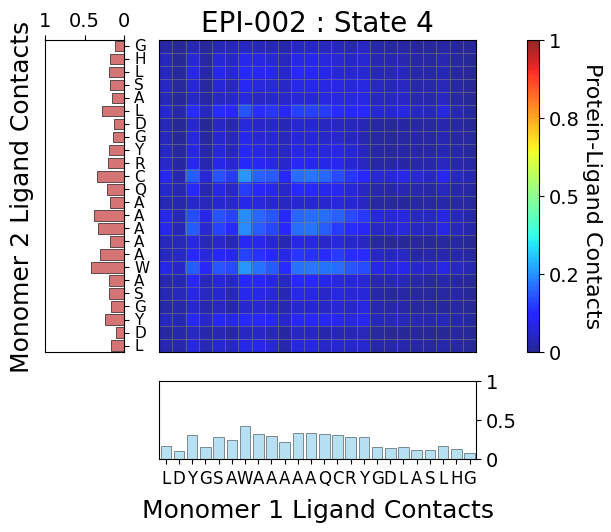

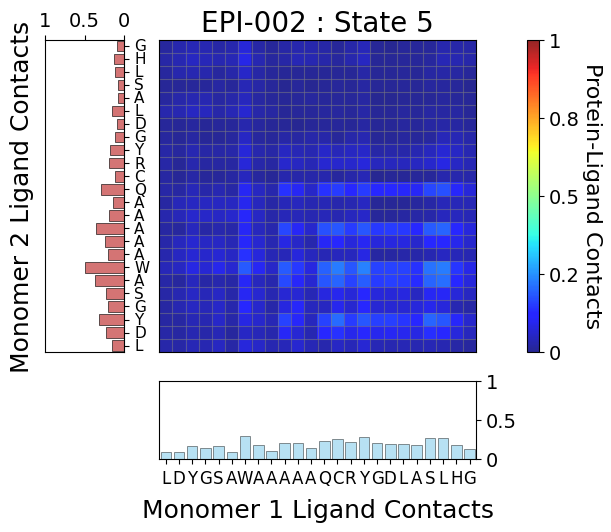

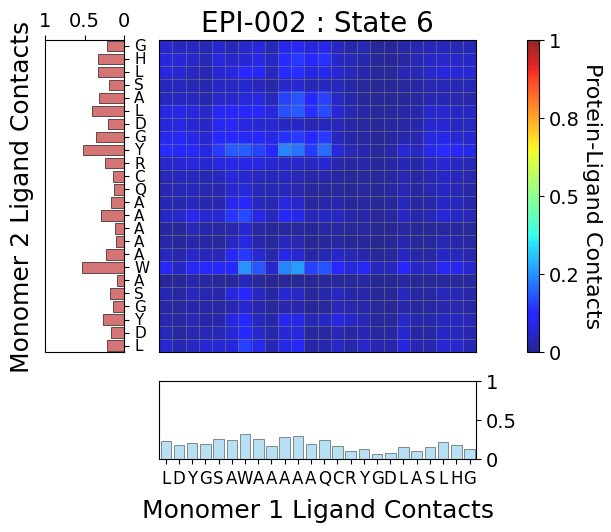

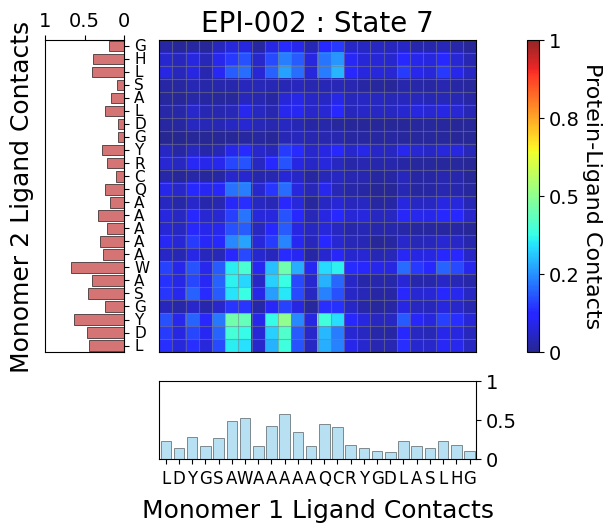

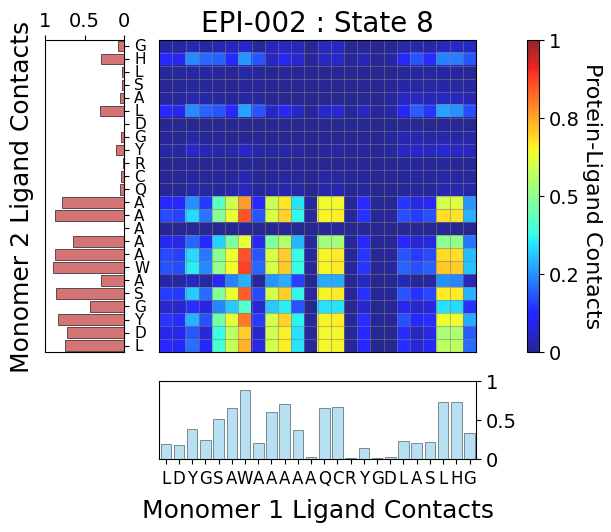

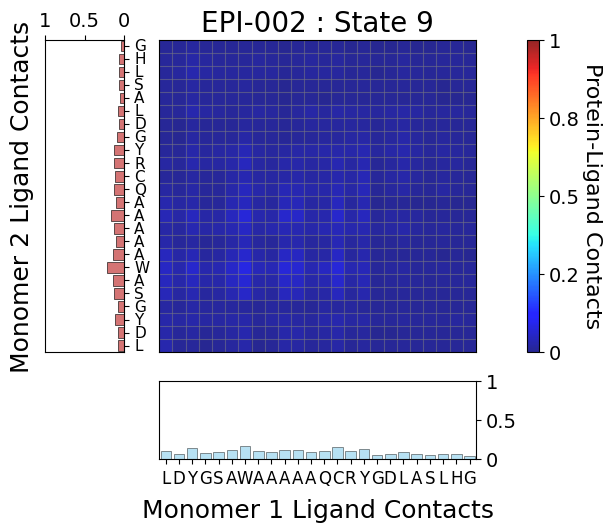

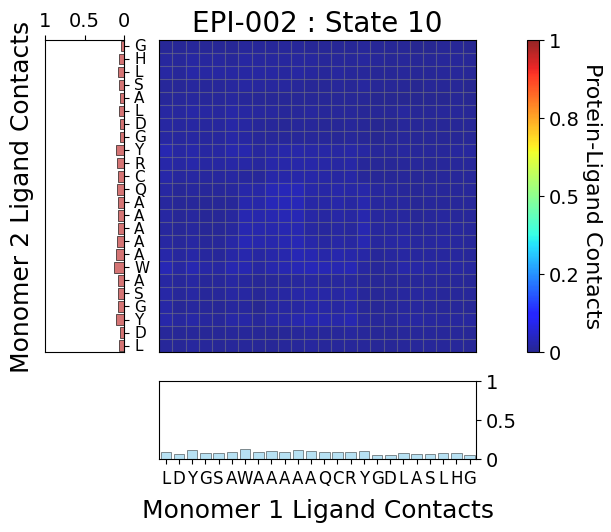

In [9]:

error = split(block_error(ligand_distances.contacts(.6))[1])
i, j = split(ligand_distances.contacts(.6))
build_matrix_boxplot_grid((i.T @ j).T / len(i),
                          i.mean(0),
                          j.mean(0),
                          bottom_errors=error[0],
                          left_errors=error[1],
                          cmap='jet',
                          title=f'{label} Ensemble',
                          bottom_title='Monomer 1 Ligand Contacts',
                          vmin=0,
                          vmax=.4,
                          marginal_max=1,
                          left_title='Monomer 2 Ligand Contancts',
                          cbar_label='Protein-Ligand Contacts',
                          ticks=codes,
                          ecolor='gray',
                          path=f'{paths[1]}/ligand_contacts_ensemble.png'
                         )

for k, frames in enumerate(frames_cl):
    i, j = split(ligand_distances.contacts(.6)[frames])
    build_matrix_boxplot_grid(matrix=(i.T @ j).T / len(frames),
                              bottom_values=i.mean(0),
                              left_values=j.mean(0),
                              cmap='jet', title=f'{label} : State {k+1}',
                              bottom_title='Monomer 1 Ligand Contacts', vmin=0, vmax=1,
                              left_title='Monomer 2 Ligand Contacts',ticks=codes,
                              cbar_label='Protein-Ligand Contacts',
                              path=f'{paths[1]}/ligand_contacts_state_{k+1}.png')

Text(0.7, 22, '14.4 ns')

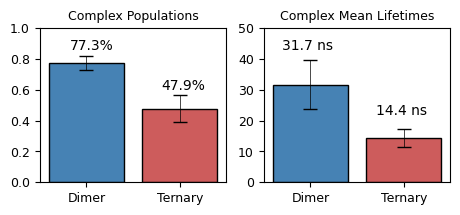

In [19]:

_, ax = plt.subplots(1, 2,
                     figsize=(5.3, 2), 
                     #dpi=500,
                    )
mu, err = block_error(np.stack([dimer, ternary], 1))


box_plot(mu,
         errors=err,
         labels='Dimer,Ternary'.split(','),
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['steelblue', 'indianred'],
         alpha=1, 
         font_scale=state_font_scale, 
         title = 'Complex Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=0.8,
         ax=ax[0])

ax[0].text(-.18, .86, f'{100 * mu[0] :.1f}%')
ax[0].text(.8, .6, f'{100 * mu[1] :.1f}%')


mu = np.array([i.mean() for i in [dimer_lengths, ternary_lengths]])
err = np.array([bootstrap(i)[-1] for i in [dimer_lengths, ternary_lengths]])

box_plot(mu,
         errors=err,
         labels='Dimer,Ternary'.split(','),
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['steelblue', 'indianred'],
         alpha=1, 
         font_scale=state_font_scale, 
         title = 'Complex Mean Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=50,
         #ylabel='Time (ns)',

         width=0.8,
         ax=ax[1])

ax[1].text(-.31, 43, f'{mu[0] :.1f} ns')
ax[1].text(.7, 22, f'{mu[1] :.1f} ns')

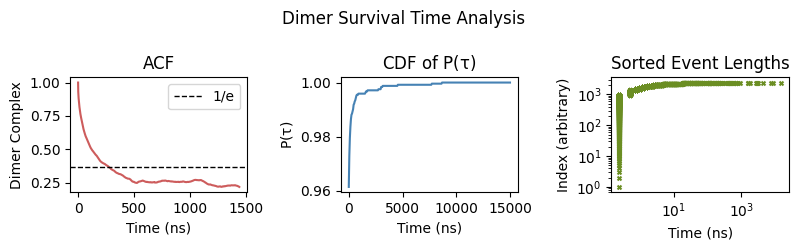

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))

ac = acf(dimer)
#get the correlation time
#tau.append(get_tau(ac))
axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
             ac[:6000],
             c="indianred",
            )
bins=300
axes[1].plot( np.linspace(0, 15000, bins), np.cumsum(pmf(dimer_lengths, bins=bins, range=(0, 15000))[0]), c='steelblue')
axes[2].scatter(dimer_lengths[::-1], np.arange(len(dimer_lengths)), c='olivedrab', s=8, marker='x')



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')
axes[2].set_xscale('log')
axes[2].set_yscale('log')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
#axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("Dimer Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Dimer Survival Time Analysis')
fig.tight_layout()

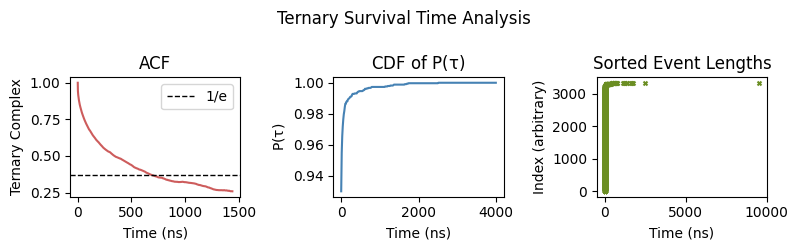

In [14]:

fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))

ac = acf(ternary)
#get the correlation time
#tau.append(get_tau(ac))
axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
             ac[:6000],
             c="indianred",
            )
bins=300
axes[1].plot( np.linspace(0, 4000, bins), np.cumsum(pmf(ternary_lengths, bins=bins, range=(0, 4000))[0]), c='steelblue')
axes[2].scatter(ternary_lengths[::-1], np.arange(len(ternary_lengths)), c='olivedrab', s=8, marker='x')



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
#axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("Ternary Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Ternary Survival Time Analysis')
fig.tight_layout()

 # Folding upon binding?

Text(0.5, 1.0, 'S$\\alpha$(t) * Protein Contacts(t + $\\tau$)')

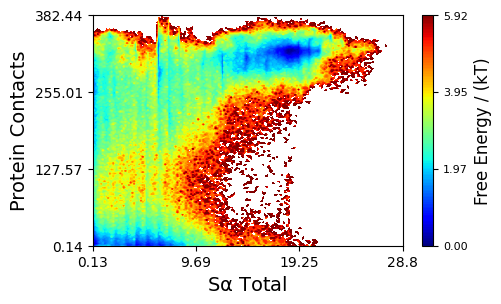

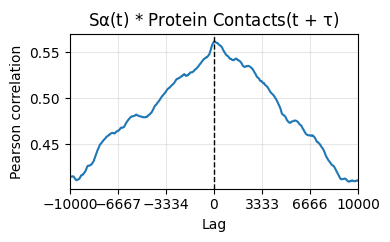

In [38]:
from writhe_tools.writhe_numba import pbc_correct
from writhe_tools.stats import cross_correlation, plot_cross_correlation
fes2d(sa.sum((0,-1)), np.exp(-.25 * ca_distances.distances**2).sum(-1), xlabel=r'S$\alpha$'+" Total", ylabel="Protein Contacts")
dist = np.power(pbc_correct(writhe.xyz[:, :24].mean(1) - writhe.xyz[:, 24:].mean(1), unitcell_lengths), 2).sum(-1)**(1/2)
lags, corr = cross_correlation(sa.sum((0,-1)),
                                       #ca_distances.contacts(1).mean(-1),
                                       np.exp(-.25 * ca_distances.distances**2).mean(-1),
                                     )
ax=plt.subplots(1, 1,figsize=(4, 2.5))[-1]
plot_cross_correlation(lags, corr, 10000, normalize=False, ax=ax)
ax.set_title(r'S$\alpha$(t) * Protein Contacts(t + $\tau$)')

Text(0.5, 1.0, 'Event Protein Contact distributions')

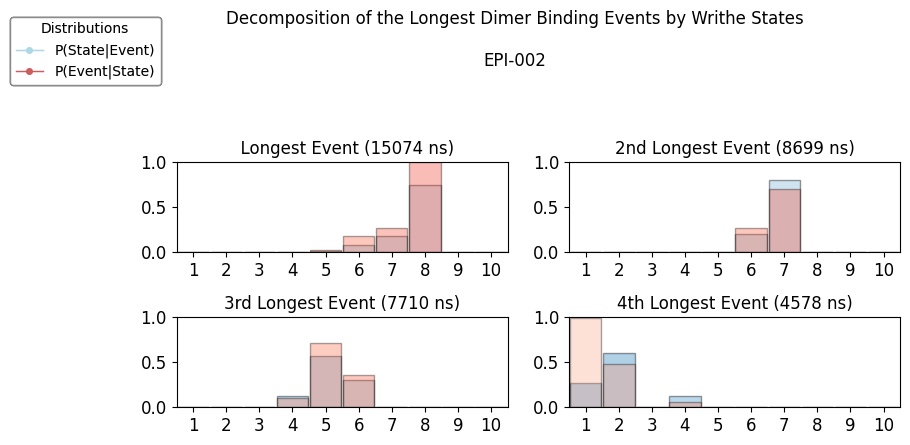

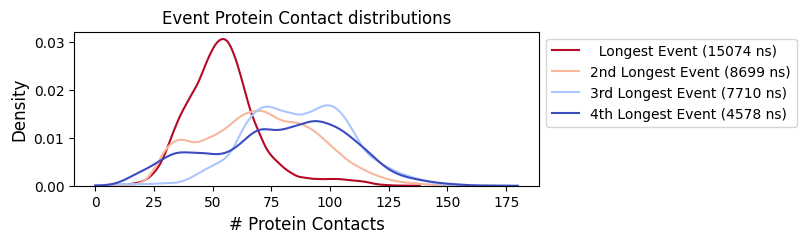

In [22]:
import seaborn as sns
fig, axes = plt.subplots(2,2, figsize=(8, 4))
event_title = dict(zip([0, 1, 2, 3], ' ,2nd,3rd,4th'.split(',')))
for i, (frames, length, ax) in enumerate(zip(dimer_events, dimer_lengths, axes.flat)):

    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)
    
    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.35, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1,
            title = f'{event_title[i]} Longest Event ({length:.0f} ns)')
    
    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
    fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1.1])
    
    fig.suptitle(f"Decomposition of the Longest Dimer Binding Events by Writhe States\n\n{label}", y=1.1)

fig.tight_layout()




fig, ax = plt.subplots(1, 1, figsize=(6,2))
for i, (frames, length, color) in enumerate(zip(dimer_events[:4], dimer_lengths, get_color_list(4,'coolwarm_r'))):
    
    sns.kdeplot(ca_distances.contacts(1)[frames].sum(-1),
                label=f'{event_title[i]} Longest Event ({length:.0f} ns)',
                common_grid=True,
                ax=ax,
                clip=(0,180),
                color=color)

ax.legend(ncol=1, bbox_to_anchor=[1,1])
ax.set_xlabel('# Protein Contacts', size=12)
ax.set_ylabel('Density', size=12)
ax.set_title('Event Protein Contact distributions', 
                #size=15,
               )

Text(0.5, 1.0, 'Event Ligand Contact distributions')

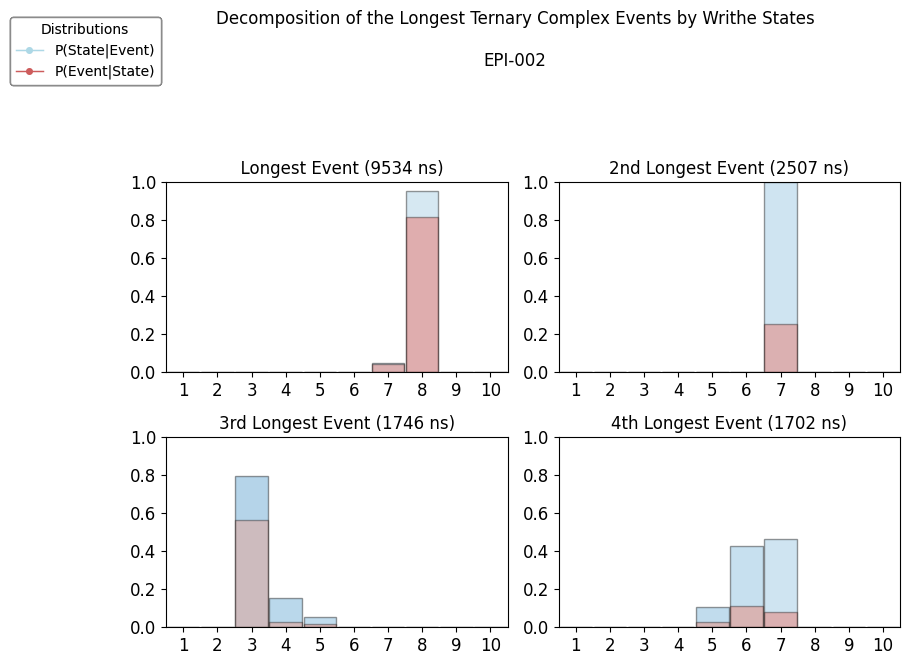

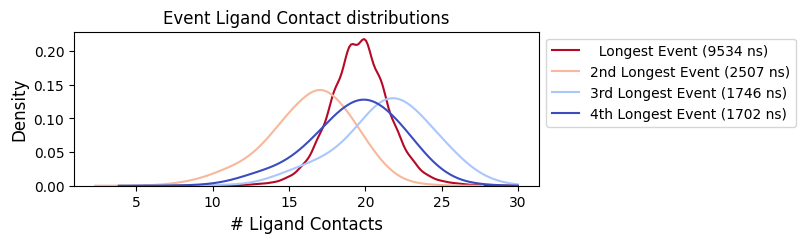

In [12]:
import seaborn as sns
fig, axes = plt.subplots(2,2, figsize=(8, 6))
event_title = dict(zip([0, 1, 2, 3], ' ,2nd,3rd,4th'.split(',')))
for i, (frames, length, ax) in enumerate(zip(ternary_events, ternary_lengths, axes.flat)):

    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)
    
    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.35, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1,
            title = f'{event_title[i]} Longest Event ({length:.0f} ns)')
    
    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
    fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1.1])
    
    fig.suptitle(f"Decomposition of the Longest Ternary Complex Events by Writhe States\n\n{label}", y=1.1)

fig.tight_layout()




fig, ax = plt.subplots(1, 1, figsize=(6,2))
for i, (frames, length, color) in enumerate(zip(ternary_events[:4], ternary_lengths, get_color_list(4,'coolwarm_r'))):
    
    sns.kdeplot(ligand_distances.contacts(.6)[frames].sum(-1),
                label=f'{event_title[i]} Longest Event ({length:.0f} ns)',
                common_grid=True,
                ax=ax,
                bw_adjust=2,
                clip=(0,30),
                color=color)

ax.legend(ncol=1, bbox_to_anchor=[1,1])
ax.set_xlabel('# Ligand Contacts', size=12)
ax.set_ylabel('Density', size=12)
ax.set_title('Event Ligand Contact distributions', 
                #size=15,
               )

In [13]:
import pandas
from pandas import DataFrame
from IPython.display import display, Markdown
cols = ['Population %', r'Protein Contacts',  r'$S\alpha$', 'Dimer %', 'Ligand Contacts', 'Ternary %']

rows = []

rows.append(group_by(dtraj, reduction=lambda x : 100 * x.sum() / len(dtraj)))

rows.append(group_by(dtraj,
                    ca_distances.contacts(1).sum(-1),
                    np.mean))


rows.append(group_by(dtraj, sa.sum((0, 2)), np.mean))

rows.append(100 * group_by(dtraj,
                           dimer,
                           np.mean))


rows.append(group_by(dtraj,
                     ligand_distances.contacts(0.6).sum(-1),
                     np.mean))


rows.append(100 * group_by(dtraj,
                           ternary,
                           np.mean))


display(Markdown(f'{label} State Averaged Observables'))
display(pandas.DataFrame(np.array(rows).T.round(1), columns=cols, index=np.arange(1, len(rows[0]) + 1)))
        
    

EPI-002 State Averaged Observables

,Population %,Protein Contacts,$S\alpha$,Dimer %,Ligand Contacts,Ternary %
1,1.2,101.8,6.8,100.0,12.4,66.3
2,5.7,56.4,8.3,93.9,15.5,75.7
3,2.5,68.2,16.0,98.5,17.7,81.8
4,9.6,47.1,10.7,84.6,10.7,55.9
5,6.1,72.8,13.4,87.7,9.3,51.3
6,6.5,65.2,13.5,90.5,10.5,62.8
7,10.0,61.1,18.2,97.3,13.4,82.5
8,11.1,53.6,18.5,100.0,18.0,95.3
9,9.0,20.2,6.4,48.8,4.9,21.5
10,38.4,34.1,3.0,61.8,4.0,19.4
